In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

### Keras
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, Lambda
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D
from keras.optimizers import Adam

## Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

## Cargamos datos desde el archivo .FPT

In [20]:
contador = 0

with open('Data/output.fpt') as archivo:
    for linea in archivo:
        line_list = linea.strip().split()
        
        if ">" not in line_list:
            lista += line_list
            
            if len(lista) == 32:
                hexadecimal = ''.join(lista)
                binario = bin(int(hexadecimal, 16))[2:].zfill(1024)
                
                if contador == 0:
                    X = np.array(list(map(int, binario))).reshape(1024, 1).T
                    contador += 1
                
                else:
                    row = np.array(list(map(int, binario))).reshape(1024, 1).T
                    X = np.concatenate((X, row), axis=0)
                              
        else:
            lista = []

## Obtenemos valores de IC50 para las moléculas

In [21]:
df = pd.read_csv('Data/IC50_filtered_original.csv')

In [4]:
y = np.log10(np.array(df['ic50_value']).reshape(4126, 1))

## Separamos datos de entrenamiento y test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Generamos red neuronal Feedforward

In [6]:
model = Sequential()

model.add(Dense(2600, input_dim=1024, activation='relu'))
model.add(Dense(1300, activation='relu'))
model.add(Dense(1300, activation='relu'))
model.add(Dense(650, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(70, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2600)              2665000   
_________________________________________________________________
dense_1 (Dense)              (None, 1300)              3381300   
_________________________________________________________________
dense_2 (Dense)              (None, 1300)              1691300   
_________________________________________________________________
dense_3 (Dense)              (None, 650)               845650    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               195300    
_________________________________________________________________
dense_5 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_6 (Dense)              (None, 70)                1

In [7]:
# Compile model
model.compile(loss='mse', optimizer='adam', metrics=["mean_absolute_percentage_error"])

checkpoint_name = 'Modelos/fp2_model.h5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data = (X_test, y_test), callbacks=callbacks_list)

Epoch 1/100
165/165 [==============================] - ETA: 0s - loss: 1.3309 - mean_absolute_percentage_error: 959192.6875
Epoch 00001: val_loss improved from inf to 0.81056, saving model to fp2_model.h5
165/165 [==============================] - 7s 40ms/step - loss: 1.3309 - mean_absolute_percentage_error: 959192.6875 - val_loss: 0.8106 - val_mean_absolute_percentage_error: 57.5102
Epoch 2/100
165/165 [==============================] - ETA: 0s - loss: 0.5485 - mean_absolute_percentage_error: 694424.0000
Epoch 00002: val_loss did not improve from 0.81056
165/165 [==============================] - 6s 38ms/step - loss: 0.5485 - mean_absolute_percentage_error: 694424.0000 - val_loss: 0.8825 - val_mean_absolute_percentage_error: 46.0417
Epoch 3/100
165/165 [==============================] - ETA: 0s - loss: 0.4059 - mean_absolute_percentage_error: 583574.0625
Epoch 00003: val_loss improved from 0.81056 to 0.60952, saving model to fp2_model.h5
165/165 [==============================] - 7s 4

In [8]:
pred_train= model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train))) 
pred_test= model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test))) 

0.21063621602697494
0.6124880107962981


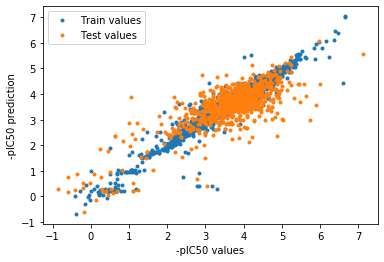

In [15]:
plt.figure(3)
plt.clf()
plt.xlabel('-pIC50 values')
plt.ylabel('-pIC50 prediction')
plt.plot(y_train, pred_train ,'.', label = 'Train values')
plt.plot(y_test, pred_test, '.', label = 'Test values')
plt.legend()
plt.savefig('Images/FP2.png')
plt.show()


In [11]:
r2_score(y_test, pred_test)

0.619774714611574